In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/new/temp/shangpinming/tfrecord/seq-basic/vocab.txt', 'vocabulary file')

model_dir='/home/gezi/new/temp/shangpinming/model/seq2seq.attention/'

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

TEXT_MAX_WORDS = 20
INPUT_TEXT_MAX_WORDS = 30

tensorflow_version: 1.2.0-rc0


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  #word_ids.append(text2ids.vocab.end_id())
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  #print(len(beams))
  #x_labels = [gbk2utf8(text2ids.vocab.key(x)).encode('utf8') for x in word_ids]
  for i, beam in enumerate(beams):
    print(gbk2utf8(text2ids.ids2text(word_ids)))
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)

    #plt.matshow(beam.alignments_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(beam.alignments_list, interpolation='nearest')
    #fig.colorbar(cax)

    #ax.set_xticklabels(['']+x_labels)
    #ax.set_yticklabels(['']+alpha)

    plt.show()
    break


  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/new/temp/shangpinming/tfrecord/seq-basic/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
predictor = melt.Predictor(model_dir)

def inference(text):
  predict(predictor, text)

ENCODE_UNK 1
restore from /home/gezi/new/temp/shangpinming/model/seq2seq.attention/model.ckpt-7.2-65000


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/shangpinming/model/seq2seq.attention/model.ckpt-7.2-65000


import graph ok /home/gezi/new/temp/shangpinming/model/seq2seq.attention/model.ckpt-7.2-65000.meta
restore ok /home/gezi/new/temp/shangpinming/model/seq2seq.attention/model.ckpt-7.2-65000


In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

word_ids [411, 21, 2640, 1733, 232, 93, 18, 324, 196, 7, 2035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 30
美国/代购/Vaseline/凡士林/深层/滋润/保湿/修复/护手/霜/护甲
美国/代购/Vaseline/凡士林/深层/滋润/保湿/修复/护手/霜/护甲
0 [2640, 6, 1733, 3, 1479, 93, 7, 2] Vaseline///凡士林/ /特效/滋润/霜/<EOS> 0.040701924127 -3.20148 -3.20148 [-0.5682382, -0.1519862, -0.092659593, -0.00047731926, -1.502073, -0.52623391, -0.35842815, -0.0013834201]


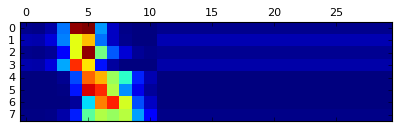

beam search using time(ms): 404.276132584


In [10]:
inference('美国代购Vaseline凡士林深层滋润保湿修复护手霜护甲')